# **심층 합성곱 생성적 적대 신경망**

In [ ]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [ ]:
# GIF를 만들기위해 설치합니다.
!pip install -q imageio

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

**데이터셋 로드**

In [ ]:
#(_,_)의 의미는 테스트세트의 input과 output을 모두 _라는 변수에 넣는 것이다.
#이렇게되면 테스트 세트의 input과 output이 동일한 변수에 덮어씌워지기 때문에 사실상 테스트세트가 가지는 의미가 없어진다.
#따라서 (_,_)는 테스트세트를 사용하지 않겠다는 의미가 된다.
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()
#astype메소드는 주어진 넘파이배열의 자료형을 결정한다.
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # 이미지를 [-1, 1]로 정규화
#이미지 데이터가 들어갈 생성자(Generator)의 출력층 활성화함수로 tanh함수를 사용하므로, tanh함수의 범위인 [-1,1]로 정규화한다.
print(train_images.shape)

(60000, 28, 28, 1)


In [ ]:
#이미지 개수
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# 데이터 배치를 만들고 섞음
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

**모델 만들기**

In [ ]:
#생성자 모델 제작 함수 정의
def make_generator_model():
    model = tf.keras.Sequential()
    #input_shape가 크기 100의 1차원 배열인 이유는 랜덤시드로 부터 이미지를 생성하기 위함이다.
    model.add(tf.keras.layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    #BatchNormalization층은 이전층의 출력을 정규화해준다.
    model.add(tf.keras.layers.BatchNormalization())
    #활성화함수 LeakyReLU를 사용
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Reshape((7, 7, 256)))
    #asser키워드는 주어진 조건이 성립하지 않으면 예외 오류를 띄웁니다.
    assert model.output_shape == (None, 7, 7, 256) # 주목: 배치사이즈로 None이 주어집니다.

    #Conv2DTranspose는 Conv2D와는 반대로 특성맵에서 입력을 예측하는 모델이다.
    #Conv2DTranspose의 출력은 Input*strides이다.
    model.add(tf.keras.layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.LeakyReLU())

    model.add(tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

In [ ]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

(1, 28, 28, 1)


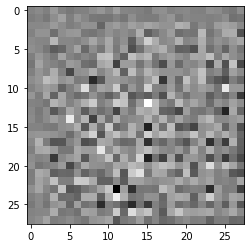

In [ ]:
#훈련을 진행하지 않고 이미지를 생성

#랜덤 input 노이즈 생성
noise = tf.random.normal([1, 100])
#케라스의 모델은 fit메서드를 사용하지 않고도 다음 코드와 같이 하나씩 훈련할 수도 있다.
#training인자를 False로 주면 해당 훈련의 결과를 모델에 반영하지 않는다.
generated_image = generator(noise, training=False)
print(generated_image.shape)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [ ]:
#감별자 생성 함수 정의
#감별자는 일반적인 CNN기반의 이미지 분류기로 생성한다.
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(tf.keras.layers.LeakyReLU())
    model.add(tf.keras.layers.Dropout(0.3))

    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(1))

    return model

In [ ]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [ ]:
#위조된 이미지로 판별을 내려본다.
decision = discriminator(generated_image)
print (decision)
#이 discriminator는 진짜 이미지에 양수를, 가짜 이미지에 음수를 출력한다.
#생성적 적대 신경망(GAN)은 아래의 값이 0(50퍼센트)이 될때까지 학습한다.
#이러한 이유는 discriminator(감별자)가 더 이상 진짜와 위조의 판단이 불가능할 경우 50퍼센트 확률로 찍기 때문이다.

tf.Tensor([[0.00039611]], shape=(1, 1), dtype=float32)


**손실함수와 옵티마이저 정의**

In [ ]:
# 이 메서드는 크로스 엔트로피 손실함수 (cross entropy loss)를 계산하기 위해 헬퍼 (helper) 함수를 반환합니다.
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
#가짜 이미지와 진짜 이미지를 얼마나 잘 판별하는지 수치화하는 손실함수 제작
def discriminator_loss(real_output, fake_output):
  #진짜 이미지 분류시 손실
  #tf.ones_like 메서드는 주어진 텐서와 같은 모양을 가지는 1로 채워진 텐서를 생성한다.
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)
  #가짜 이미지 분류시 손실
  #tf.zeros_like 메서드는 주어진 텐서와 같은 모양을 가지는 0으로 채워진 텐서를 생성한다.
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
#감별자를 얼마나 잘 속였는지에 대해 수치화하는 손실함수를 제작
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
#각각의 옵티마이저 정의
#Adam은 적응형 옵티마이저이기 때문에 따로 선언해준다.
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

**체크포인트**

In [ ]:
#os모듈은 운영체제에서 제공하는 여러 기능들을 파이썬에서 사용할 수 있게 해준다.
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

**훈련 루프 설정**

In [ ]:
EPOCHS = 50
#입력값 노이즈의 크기를 지정
noise_dim = 100
num_examples_to_generate = 16

# 이 시드를 시간이 지나도 재활용하겠습니다. 
# (GIF 애니메이션에서 진전 내용을 시각화하는데 쉽기 때문입니다.) 
#tf.random.normal메서드는 주어진 모양으로 0~1까지의 랜덤한 실수로 채워줍니다.
#상세:https://www.tensorflow.org/api_docs/python/tf/random/normal
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [ ]:
#한 단계 학습하는 방법을 텐서플로우 함수로 정의
#tf.function 데코레이터로 정의한 함수는 텐서플로우의 함수 기능을 지닙니다.
#https://www.tensorflow.org/guide/function?hl=ko
@tf.function
def train_step(images):
  #랜덤 노이즈(시드)생성
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  #tf.GradientTape는 컨텍스트 안에서 일어난 모든 연산을 기록해서 자동미분하여 Gradient(기울기)값을 뽑아준다.
  #tf.GradientTape객체는 기본적으로 with구문 하위에 관찰할수 있는 모든 대상을 관찰한다. 
  #https://www.tensorflow.org/guide/autodiff?hl=ko
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    #이미지를 위조하고 학습
    generated_images = generator(noise, training=True)

    #진짜 이미지를 판별하고 학습
    real_output = discriminator(images, training=True)
    #가짜 이미지를 판별하고 학습
    fake_output = discriminator(generated_images, training=True)

    #generator와 discriminator의 손실함수에 각각의 출력을 넣어 이번 학습의 손실값을 저장
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  #GradientTape의 gradient메서드는 관찰한 적 있는 변수의 도함수를 뽑아내줍니다.
  #gradient(x,y) -> y에 대한 x의 도함수
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  #이번 학습의 결과를 옵티마이저에 업데이트
  #zip 함수는 동일한 길이를 가진 배열을 묶어준다.
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
#이와 같은 low-level의 학습 커스터마이징은 아래의 포스팅에 자세히 나와있다.
#https://hwiyong.tistory.com/110

**zip함수 이해하기**

In [ ]:
#https://wikidocs.net/32#zip
print(list(zip([1, 2, 3], [4, 5, 6])))
print(list(zip("abc", "def")))

[(1, 4), (2, 5), (3, 6)]
[('a', 'd'), ('b', 'e'), ('c', 'f')]


In [ ]:
#IPython.display모듈은 데이터셋을 HTML형식으로 출력해준다.
from IPython import display
#시간데이터를 다루기위한 time 모듈
import time

#학습을 위한 함수 정의
def train(dataset, epochs):
  for epoch in range(epochs):
    #time.time()메서드는 "Epoch Time"을 출력해준다.
    start = time.time()

    #dataset을 루프 돌려서 모든 데이터 셋을 학습
    for image_batch in dataset:
      train_step(image_batch)

    # GIF를 위한 이미지를 바로 생성합니다.
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # 15 에포크가 지날 때마다 모델을 저장합니다.
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    # print (' 에포크 {} 에서 걸린 시간은 {} 초 입니다'.format(epoch +1, time.time()-start))
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # 마지막 에포크가 끝난 후 생성합니다.
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

**이미지 생성및 저장**

In [ ]:
def generate_and_save_images(model, epoch, test_input):
  # `training`이 False로 맞춰진 것을 주목하세요.
  # 이렇게 하면 (배치정규화를 포함하여) 모든 층들이 추론 모드로 실행됩니다. 
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

**모델 훈련**

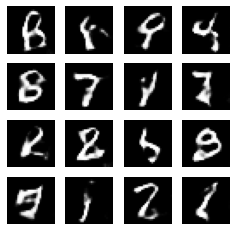

CPU times: user 2min 58s, sys: 27 s, total: 3min 25s
Wall time: 11min 39s


In [ ]:
%%time
train(train_dataset, EPOCHS)

In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

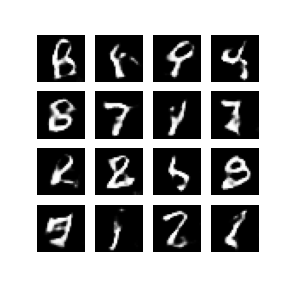

In [ ]:
import PIL

# 에포크 숫자를 사용하여 하나의 이미지를 보여줍니다.
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))
display_image(EPOCHS)

In [ ]:
#ttung102802@gmail.com
from google.colab import drive
from IPython.display import Image
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
import imageio
import glob

anim_file = '/gdrive/My Drive/Colab Notebooks/dcgan.gif'

#imageio로 훈련중에 저장된 이미지로 gif를 만든다
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

# **적용**

In [ ]:
(train_input, train_target), (test_input, test_target) = tf.keras.datasets.fashion_mnist.load_data()

#이미지를 높이 1의 3차원 배열로 바꾸어 전체 배열을 4차원으로 바꾸었다.
train_scaled = train_input.reshape(-1, 28, 28, 1) / 255.0

In [ ]:
print(train_scaled.shape)

#데이터의 크기는 MNIST랑 동일하므로 BUFFER_SIZE와 BATCH_SIZE를 그대로 사용한다.
fashion_train_dataset = tf.data.Dataset.from_tensor_slices(train_scaled).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

(60000, 28, 28, 1)


In [ ]:
#데이터의 크기가 완전히 동일하므로 모델과 옵티마이저를 초기화만 해준다.
discriminator = make_discriminator_model()
generator = make_generator_model()

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

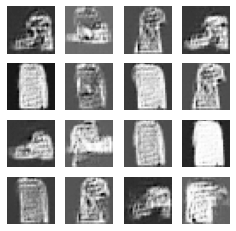

CPU times: user 3min 6s, sys: 23.5 s, total: 3min 30s
Wall time: 11min 40s


In [ ]:
%%time

train(fashion_train_dataset,50)

In [ ]:
anim_file = '/gdrive/My Drive/Colab Notebooks/fdgan.gif'

#imageio로 훈련중에 저장된 이미지로 gif를 만든다
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)